# 1 - NER PyTorch - version française

In [2]:
%load_ext autoreload
%autoreload 2

import os
import time

import joblib
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup

os.chdir('..')

from ner_pytorch.config.params import PARAMS
from ner_pytorch.dataset import EntityDataset
from ner_pytorch.engine import eval_fn, train_fn, prédit_single_doc
from ner_pytorch.model import EntityModel
from ner_pytorch.preprocessing import process_data
from ner_pytorch.utils import *

## Chargement des données

In [4]:
if PARAMS.LANGUAGE == 'fr':
    data = pd.read_feather(PARAMS.PATHS_FR.TRAIN)
    data = data.rename(columns={'Phrase': 'Sentence #', 'Mot': 'Word', 'Label': 'Tag'})
elif PARAMS.LANGUAGE == 'en':
    data = pd.read_csv(PARAMS.PATHS_EN.TRAIN, encoding='latin-1').drop('POS', axis=1)
    data["Sentence #"] = data["Sentence #"].fillna(method='ffill')
    data['ID'] = data['Sentence #']
data.head(7)

,Sentence #,Word,Tag,ID
0,Sentence: 1,Thousands,O,Sentence: 1
1,Sentence: 1,of,O,Sentence: 1
2,Sentence: 1,demonstrators,O,Sentence: 1
3,Sentence: 1,have,O,Sentence: 1
4,Sentence: 1,marched,O,Sentence: 1
5,Sentence: 1,through,O,Sentence: 1
6,Sentence: 1,London,B-geo,Sentence: 1


En réalité, nous ne nous intéressons qu'à la prédiction des ORG, pour lesquelles 3 labels sont possibles :
- B-org
- I-org
- O

In [5]:
data['Tag'] = data.Tag.mask(~data.Tag.isin(['B-org', 'I-org', 'O']), 'O')
data.Tag.value_counts(normalize=True)

O        0.964784
B-org    0.019210
I-org    0.016006
Name: Tag, dtype: float64

In [6]:
num_tag = data.Tag.nunique()
print(f'Tag {num_tag} categories :', data.Tag.unique(), end='\n\n')

data.shape
data.query("ID == 'Wikineural - Phrase 11022'")

Tag 3 categories : ['O' 'B-org' 'I-org']



(1048575, 4)

,Sentence #,Word,Tag,ID


In [7]:
sentences, tag, ordinal_enc_NER = process_data(data)
joblib.dump(ordinal_enc_NER, f'data/outputs/ordinal_enc_NER_{PARAMS.LANGUAGE}.joblib')

['data/outputs/ordinal_enc_NER_en.joblib']

In [8]:
# Démo : 
i = 6
print(sentences[i], end='\n')
print(tag[i], end='\n')
print(ordinal_enc_NER.categories_, end='\n')

['He', 'said', 'last', 'week', "'s", 'tsunami', 'and', 'the', 'massive', 'underwater', 'earthquake', 'that', 'triggered', 'it', 'has', 'affected', 'millions', 'in', 'Asia', 'and', 'Africa', '.']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[array(['O', 'B-org', 'I-org'], dtype=object)]


## Split du jeu de données
On split notre jeu de données de la façon suivante :
- `test` = 20%
- `train` = [`minitrain`, `valid`] = 80%
- `minitrain` = 60%
- `valid` = 20%

In [9]:
len_test = int(PARAMS.SAMPLE_SIZES.TEST * len(sentences))
len_valid = int(PARAMS.SAMPLE_SIZES.VALID * len(sentences))
autre = ordinal_enc_NER.transform([['O']]).item()

# En présence d'un jeu déséquilibré, il vaut mieux stratifier :
strat_tag = [len([_ for _ in tag[i] if _ != autre]) > 0 for i in range(len(tag))]
(
    sentences_train, sentences_test,
    tag_train, tag_test
) = train_test_split(sentences, tag, random_state=PARAMS.SEED, 
                     test_size=len_test, stratify=strat_tag, shuffle=True)

strat_tag_train = [len([_ for _ in tag_train[i] if _ != autre]) > 0 for i in range(len(tag_train))]
(
    sentences_minitrain, sentences_valid,
    tag_minitrain, tag_valid
) = train_test_split(sentences_train, tag_train, random_state=PARAMS.SEED, 
                     test_size=len_valid, stratify=strat_tag_train, shuffle=True)

# Pour se rassurer sur la bonne représentativité de chaque classe dans les échantillons stratifiés : 
pd.Series(np.concatenate(tag_train)).value_counts(normalize=True)
pd.Series(np.concatenate(tag_valid)).value_counts(normalize=True)

len(sentences_minitrain), len(sentences_valid), len(sentences_test)

0.0    0.964808
1.0    0.019224
2.0    0.015968
dtype: float64

0.0    0.965036
1.0    0.018949
2.0    0.016014
dtype: float64

(28777, 9591, 9591)

In [10]:
minitrain_dataset = EntityDataset(
    texts=sentences_minitrain, tags=tag_minitrain
)
minitrain_data_loader = DataLoader(
    minitrain_dataset, batch_size=PARAMS.MODEL.TRAIN_BATCH_SIZE, num_workers=16 
)

valid_dataset = EntityDataset(
    texts=sentences_valid, tags=tag_valid
)
valid_data_loader = DataLoader(
    valid_dataset, batch_size=PARAMS.MODEL.VALID_BATCH_SIZE, num_workers=16
)

test_dataset = EntityDataset(
    texts=sentences_test, tags=tag_test
)
test_data_loader = DataLoader(
    test_dataset, batch_size=PARAMS.MODEL.VALID_BATCH_SIZE, num_workers=16
)

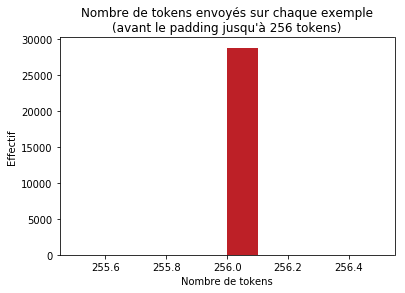

In [11]:
# Comment choisir PARAMS.MODEL.MAX_SENTENCE_LEN (= le nombre de tokens envoyés) ?
len_sen = [(_['input_ids'] != 1).sum().item() for _ in minitrain_dataset]
titre = "Nombre de tokens envoyés sur chaque exemple\n"
titre += f"(avant le padding jusqu'à {PARAMS.MODEL.MAX_SENTENCE_LEN} tokens)"
plt.title(titre)
plt.xlabel('Nombre de tokens')
plt.ylabel('Effectif')
plt.hist(pd.Series(len_sen), color='#bd2027') ;

In [12]:
i = 40
print(test_dataset.texts[i])
for key, value in test_dataset[i].items():
    print(key + ':', value)

['The', 'Spanish', 'troops', 'will', 'join', 'the', 'European', 'Union', 'force', 'sent', 'to', 'protect', 'ships', 'against', 'hijackings', 'and', 'attacks', 'by', 'Somali', 'pirates', '.']
input_ids: tensor([  101,  1996,  3009,  3629,  2097,  3693,  1996,  2647,  2586,  2486,
         2741,  2000,  4047,  3719,  2114,  7632, 17364,  8613,  1998,  4491,
         2011, 16831,  8350,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    

## Expériences pré-entraînement

Avant de lancer le modèle, quelle _loss_ serait considérée comme statisfaisante ? Calculons à l'avance les loss que donneraient :

- un modèle qui prédit aléatoirement 
- un modèle qui prédit la classe modale ("O")
- un modèle qui prédit de façon satisfaisante, avec une accuracy donnée*
- un modèle oracle (prédiction parfaite)

*Remarque : pour deux modèles qui produisent la même accuracy fixée, l'un peut être meilleur que l'autre ! En effet, les probas prédites peuvent être plus ou moins proches de la réalité, même si elles peuvent résulter en des prédictions binaires identiques (et donc en la même accuracy).

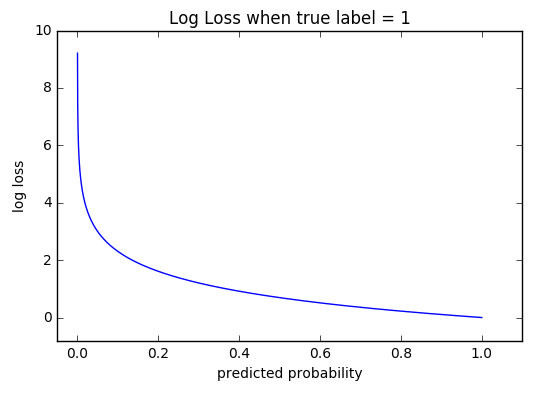

In [13]:
loss_ce = nn.CrossEntropyLoss(reduction='mean')
y_true = torch.tensor(ordinal_enc_NER.transform(data[['Tag']]), dtype=torch.long).view(-1)

y_true_ohe_parfait = torch.tensor(
    pd.get_dummies(y_true).astype(float).replace(0, -1234).to_numpy(),
    dtype=torch.float
)

# -3 est un nombre arbitraire qui affecte à la bonne classe une proba de 5%.
y_true_ohe = torch.tensor(
    pd.get_dummies(y_true).astype(float).replace(0, -3).to_numpy(),
    dtype=torch.float
)

In [14]:
#  Modèle oracle :
y_pred = y_true_ohe_parfait.detach()
print('Loss oracle :', loss_ce(y_pred, y_true))

# Modèle avec une accuracy de 98 %
# Pour rappel, une accuracy en dessous de 96 % est mauvaise !
# → data.Tag.value_counts(normalize=True)
accuracy_souhaitée = 0.98
nb_lignes_à_erroring = int((1 - accuracy_souhaitée) * y_true.shape[0])
y_pred = y_true_ohe.detach()
y_pred[0:nb_lignes_à_erroring, :] = shift_tensor(y_pred[0:nb_lignes_à_erroring, :])
print("Loss d'un modèle satisfaisant :", loss_ce(y_pred, y_true))

# Modèle qui prédit la classe modale : 
classe_modale = data.Tag.value_counts().nlargest(1).index[0]
y_pred = np.full((len(data), num_tag), -3)
y_pred[:, int(ordinal_enc_NER.transform([[classe_modale]]).item())] = 1
y_pred = torch.tensor(y_pred, dtype=torch.float)
print("Loss du modèle qui prédit argcount :", loss_ce(y_pred, y_true))

# Modèle aléatoire :
y_pred = torch.tensor(
    pd.get_dummies(torch.randint(0, num_tag, (len(data),))).astype(float).replace(0, -3).to_numpy(),
    dtype=torch.float
)
print("Loss d'un modèle aléatoire :", loss_ce(y_pred, y_true))

Loss oracle : tensor(0.)
Loss d'un modèle satisfaisant : tensor(0.1160)
Loss du modèle qui prédit argcount : tensor(0.1768)
Loss d'un modèle aléatoire : tensor(2.7012)


## Paramétrage

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [16]:
model = EntityModel(num_tag=num_tag)
model.to(device);

Some weights of the model checkpoint at data/inputs/models/bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkp

In [17]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

In [18]:
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [19]:
num_train_steps = int(len(sentences_minitrain) / PARAMS.MODEL.TRAIN_BATCH_SIZE * PARAMS.MODEL.EPOCHS)
print(f"{num_train_steps} batchs vont être envoyés dans le réseau au cours de {PARAMS.MODEL.EPOCHS} epochs.")

optimizer = torch.optim.AdamW(optimizer_parameters, lr=PARAMS.MODEL.LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

1798 batchs vont être envoyés dans le réseau au cours de 2 epochs.


## Entraînement

In [20]:
best_loss = np.inf

pbar = tqdm(range(PARAMS.MODEL.EPOCHS))
for num_epoch, epoch in enumerate(pbar):
    train_loss = train_fn(minitrain_data_loader, model, optimizer,
                          device, scheduler, pbar=pbar, num_epoch=num_epoch)
    
    # On évalue le modèle à la fin de chaque epoch
    valid_loss = eval_fn(valid_data_loader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {valid_loss}")
    
    if valid_loss < best_loss:
        torch.save(
            model.state_dict(), 
            PARAMS.PATHS_FR.MODEL_SAVED if PARAMS.LANGUAGE == 'fr' else PARAMS.PATHS_EN.MODEL_SAVED
        )
        best_loss = valid_loss

  0%|          | 0/2 [00:00<?, ?it/s]

Batch #0 : loss = 1.165236
Batch #10 : loss = 0.320315
Batch #20 : loss = 0.325595
Batch #30 : loss = 0.245898
Batch #40 : loss = 0.179366
Batch #50 : loss = 0.205223
Batch #60 : loss = 0.257891
Batch #70 : loss = 0.223360
Batch #80 : loss = 0.212335
Batch #90 : loss = 0.199407
Batch #100 : loss = 0.255920
Batch #110 : loss = 0.225137
Batch #120 : loss = 0.197723
Batch #130 : loss = 0.189815
Batch #140 : loss = 0.207400
Batch #150 : loss = 0.259790
Batch #160 : loss = 0.219603
Batch #170 : loss = 0.181440
Batch #180 : loss = 0.178033
Batch #190 : loss = 0.182992
Batch #200 : loss = 0.245723
Batch #210 : loss = 0.180438
Batch #220 : loss = 0.189914
Batch #230 : loss = 0.190706
Batch #240 : loss = 0.208270
Batch #250 : loss = 0.214599
Batch #260 : loss = 0.204330
Batch #270 : loss = 0.171218
Batch #280 : loss = 0.226916
Batch #290 : loss = 0.166133
Batch #300 : loss = 0.176692
Batch #310 : loss = 0.207779
Batch #320 : loss = 0.209532
Batch #330 : loss = 0.176477
Batch #340 : loss = 0.179

## Prédictions

Utilisons le modèle finetuné pour prédire une nouvelle phrase.

In [21]:
# On désérialise le meilleur modèle enregistré :
model = EntityModel(num_tag=PARAMS.NUM_LABELS)
model.load_state_dict(torch.load(f'data/models/model_trained_{PARAMS.LANGUAGE}.bin'))

ordinal_enc_NER = joblib.load(f'data/outputs/ordinal_enc_NER_{PARAMS.LANGUAGE}.joblib')

Some weights of the model checkpoint at data/inputs/models/bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkp

<All keys matched successfully>

### Prédictions sur l'échantillon Test

In [22]:
i = 422 # 423
single_example = test_dataset[i]
print(' '.join(test_dataset.texts[i]))

single_example = {k: single_example[k].unsqueeze(0) for k in single_example}
with torch.no_grad():
    _ = model.eval()
    loss, output = model(**single_example)

# Retrait des tokens qui ne contribuent pas à la loss (CLS, SEP, PAD) :
output = output[single_example['attention_mask'] == 1]

predictions_probas = nn.functional.softmax(output, dim=1).detach().squeeze()
predictions_probas, predictions_classes = torch.max(predictions_probas, dim=1)

On Thursday , Israeli troops killed a Palestinian gunman as he attempted to infiltrate the same settlement , in a botched attack that was claimed by the militant group , Hamas .


In [23]:
nb_tokens = single_example['attention_mask'].sum().item()
ids = single_example['input_ids'].squeeze()[:nb_tokens]

pd.DataFrame({
    'token_text': [EntityDataset.tokenizer.decode([token]) for token in ids],
    'token_id': ids,
    'y_true': ordinal_enc_NER.inverse_transform(single_example['labels'].squeeze()[:nb_tokens].reshape(-1, 1)).squeeze(),
    'pred_label': ordinal_enc_NER.inverse_transform(predictions_classes.reshape(-1, 1)).squeeze(),
    'pred_code': predictions_classes,    
    'class_proba': predictions_probas
}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
token_text,[CLS],on,thursday,",",israeli,troops,killed,a,palestinian,gun,##man,as,he,attempted,to,infiltrate,the,same,settlement,",",in,a,bot,##ched,attack,that,was,claimed,by,the,militant,group,",",hamas,.,[SEP]
token_id,101,2006,9432,1010,5611,3629,2730,1037,9302,3282,2386,2004,2002,4692,2000,29543,1996,2168,4093,1010,1999,1037,28516,7690,2886,2008,2001,3555,2011,1996,16830,2177,1010,22129,1012,102
y_true,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-org,O,O
pred_label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-org,O,O
pred_code,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
class_proba,0.999981,0.999982,0.99998,0.999978,0.999976,0.99998,0.999982,0.999982,0.999978,0.999979,0.999982,0.999982,0.999982,0.999982,0.999982,0.99998,0.999981,0.999978,0.999976,0.999979,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999981,0.999979,0.999934,0.999945,0.999479,0.995613,0.99998,0.999951


On remarque que la base d'entraînement est parfois mal labélisée... cf exemples 415, ou 4222. Sur l'exemple `sentences_test[4222]`, on voit que le modèle arrive même à corriger une erreur de labélisation dans l'échantillon test !

### Prédictions sur notre propre texte

In [26]:
# Succès
doc = "Le feu s'est déclaré en toute fin d'après-midi au sein de l'entreprise Génération piscine, spécialisée dans la fabrication de coques  polyester de piscines"
doc = "Un important incendie brûle une dizaine d'hectares à Piolenc. Le feu est parti de la pizzeria dolce vita et a fait au moins 4 morts."
doc = "D'importants travaux sont menés par le grand paris express pendant tout l'été."
doc = 'DIGITALDUNE fabrique des logiciels permettant la conception de maquettes en 3D.'
doc = "Synergie emballage est spécialisée dans le secteur d'activité du sciage et rabotage du bois. Selon les premiers éléments recueillis sur place, le feu serait parti dans l'une des trois travées de stockage de copeaux de bois."
doc = "Pour la quatrième fois en un mois, l'équipe du Service incendie de Matane est intervenue à l'usine GDS Valoribois de Matane pour une alerte incendie."
doc = "Les équipe de GDS tentent de trouver la source de ce problème récurrent, explique le responsable du service incendie."
doc = "Les locaux de l'entreprise CPMO, entreprise de machines-outils, ont totalement été détruits par les flammes dans la nuit de dimanche à lundi."
doc = "Coup de chaud pour l'entreprise Recaero. Basée dans le parc technologique Delta Sud à Verniolle, l'industrie aéronautique qui fait du traitement de surface et de l'usinage a eu une grosse frayeur ce mercredi 15 juin"
doc = "L’incendie est parti du premier étage du bâtiment de l’entreprise TGS."
doc = "Un incendie s'est déclaré ce vendredi vers 13h30 à La-Tour-en-Maurienne (Savoie) à l'usine Poudres Hermillon, qui fabrique de la poudre d'aluminium."
doc = "Il était aux alentours de 21 heures samedi 18 juin 2022 quand une coupure totale d’électricité s’est produite dans l’usine Mat Friction, seul fabricant français de plaquettes de frein."
doc = "La cuve d'une chaudière à huile a pris feu dans un local de l’entreprise de Calaire Chimie."
doc = "Samedi 18 juin vers 15 h 30, les pompiers sont intervenus sur un feu qui s’était déclaré dans un bâtiment de stockage de l’entreprise Méricq, au sein de la zone d’activité Mestre-Marty à Estillac."
doc = "Dimanche 19 juin, aux alentours de 17 heures, un incendie s’est déclaré à l'entreprise Priméale, grossiste en fruits et légumes."


# Fail mais de peu
# doc = "Un incendie majeur touche l'usine de recyclage de Smurfit Kappa au Royaume-Uni."
# doc = 'Un incendie dans la nuit de lundi à mardi à Annecy dans un supermarché Carrefour, celui situé rue de Genève.' # + 'de', et ça passe
# doc = "Ce lundi 13 juin, un important feu a ravagé le camping de l'Espiguette, situé au Grau-du-Roi, dans le Gard"
# doc = "L'entreprise Florentaise est spécialisée dans la fabrication de composts végétaux. Vers minuit, le feu est parti d'un tableau électrique." # Florentin, et ça passe
# doc = "Un incendie s’est déclaré jeudi soir à l’usine de traitement de déchets de Vadec, à Colombier."
# doc = "Lorsque le feu a pris dans le hall principal de la scierie Girard, rue Jean-Louis Guiot dans la zone industrielle de Neuve-Église (vallée de Villé)."
# doc = "Un transformateur électrique de 20 000 volts situé à proximité immédiate de l'entreprise Saunier-Duval, à Nantes, a pris feu vers 1 h du matin, dimanche 19 juin. Il n’y a pas eu de blessé."

df = prédit_single_doc(doc, model=model, tokenizer=EntityDataset.tokenizer, 
                      max_length=PARAMS.MODEL.MAX_SENTENCE_LEN, 
                      label_enc=ordinal_enc_NER)
df

,token_id,pred_code,pred_label,class_proba
token_text,,,,
<s>,5,0,O,0.948936
Dimanche,6818,0,O,0.950873
19,653,0,O,0.949647
juin,522,0,O,0.950653
",",7,0,O,0.951624
aux,68,0,O,0.951660
alentours,5660,0,O,0.951429
de,8,0,O,0.951604
17,458,0,O,0.951491
